# Рекомендация тарифов

В моем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы . Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — была произведенна заранее.

Построим модель с максимально большим значением *accuracy*. Проект будут считаться успешным при доли правильнно предсказанных ответов равным не меньше 0.75. 

# Рекомендация тарифов. 

В данной работе, будет проделанна работа, по реализации модели которая поможет оператору мобильной связи "Мегалайн" проанализировать поведение клиентов с новыми тарифами "Смарт" и "Ультра", после на основе результата модели определить (предсказать) какой тариф  больше подойдет тому или другому новому клиенту.
___

Импорт библиотек, необходимых для дальнейшей работы.

In [2]:
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

## Откройте и изучите файл

In [3]:
data = pd.read_csv('users_behavior.csv')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Таблица выглядит корректной, выведем всю основную информацию о ней.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Всего 3214 ячеек без пропусков с 5 колонками. На последок, проверим и посмотрим на их гистограммы.

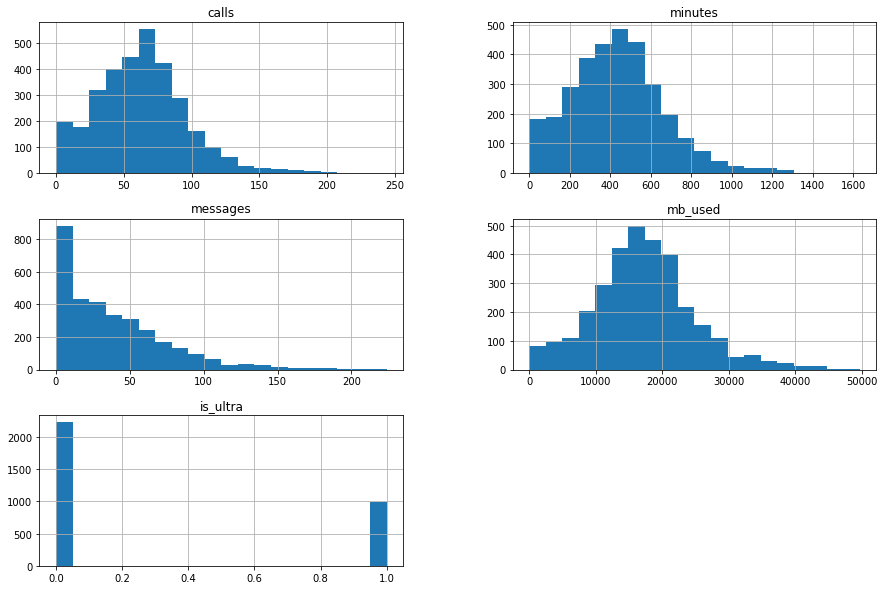

In [4]:
data.hist(figsize=(15,10), bins=20);

_Здесь тоже все хорошо, диаграммы без выбросов, и напоминают распределенние Пуассона, что является признаком корректности. `is ultra`  же имеет всего две колонки, неудивительно так-как это колонка с булевым типом. По ней можно сказать, что пользователей с тарифом "Смарт" больше в два раза чем с тарифом "Ультра". Также взглянем на корреляцию признаков нашей таблицы._
___

In [5]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Видна большая корреляция у `calls` и `minutes`. Интересующая же нас колонка `is_ultra` имеет наименьшую корреляцию с `mb_used`.

## Разбейте данные на выборки

Чтобы разбить на выборки необходимо, определиться с признаками, по которым модель будет определять ключевое качество, и этот самое ключевое качество. Зададим целью `target` колонку нашей таблицы `is_ultra` которая хранит в себе информацию о тарифе. А все остальные данные будут нашими особенностями `features`.

In [6]:
features = data.drop('is_ultra', axis=1)
target = data.is_ultra

Теперь мы можем разделить на три выборки. Выборка для обучения, будет заключать в себе 75% процентов от всей таблицы, это позволит обучить модель качественно. Так сначала обучим модель с выборкой для обучения 75% и с выборкой для тестирования в 25% от основоной таблицы.

In [7]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=2503, stratify=target)
#Проверка
print('Размер обучающей выборки:',features_train.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])

Размер обучающей выборки: 2410
Размер тестовой выборки: 804


Также нам потребуется, выборка для итоговой проверки нашей модели. Для этого разделим нашу промежуточную выборку для теста пополам. И в итоге у нас получится: 
* Для обучения = 75%;
* Для теста = 12.5%;
* Для валидации = 12.5%.

In [8]:
features_test, features_valid, target_test , target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=302, stratify=target_test)
print('Размер тестовой выборки:',features_test.shape[0])
print('Размер валидационной выборки:',features_valid.shape[0])

Размер тестовой выборки: 402
Размер валидационной выборки: 402


Теперь с полученным разделением данных, можно приступить к обучению нескольких моделей.
___

## Исследуйте модели

С данной таблицей, в которой все колонка имееет тип `bool`, мы приследуем цели которые достигнем при помощи **классификации**. Дальнейшая работа с данными будет основанна на особенностях и правилах работы с ней. Так качество той или иной модели мы будем определять при помощи метрики правильности модели `accuracy`. Так же выведем время работы кода для 

__Первую модель, обучим как "Дерево решений". На ее качество будем влиять, значением глубины ее дерева решений. Сделаем это в цикле который и выведет наименьшую ошибку которая поможет нам определить наилучшую модель.__

In [9]:
#Задаем начальное сильно завышеннок значение переменной(хранящая в будующем ответ),
# с которым будем сравнивать полученные значения.
accuracy = 0
best_model_dec_tree = None
best_depth = 0
train_accuracy = []
valid_accuracy = []

# В цикле пройдемся по 10 значчениям глубины дерева и определим, дерево с наибольшей точностью.
for depth in tqdm(range(1,51)):  
    # Создаем модель "Дерево решений"
    # max_depth = depth 
    model_dec_tree = DecisionTreeClassifier(random_state=2503, max_depth = depth) 
    # Обучаем модель
    model_dec_tree.fit(features_train, target_train)
    # Расчитываем правильность
    accuracy_score_valid = accuracy_score(target_valid, 
                                          model_dec_tree.predict(features_valid))
    valid_accuracy.append(accuracy_score_valid)
    
    accuracy_score_train = accuracy_score(target_train, 
                                          model_dec_tree.predict(features_train))
    train_accuracy.append(accuracy_score_train)
    
    if accuracy_score_valid > accuracy:
        accuracy = accuracy_score_valid
        best_model_dec_tree = model_dec_tree
        best_depth = depth
print(f'Модель с наименьшей средней квадратичной ошибкой равной {round(accuracy, 4)} имеет глубину {best_depth}.')

100%|██████████| 50/50 [00:00<00:00, 64.90it/s]

Модель с наименьшей средней квадратичной ошибкой равной 0.7935 имеет глубину 10.


Модель "Дерево решений" с глубиной равной 10 и будет нашей первым кандидатом для сравнения с другими. Но для начала построим график метрики првильности при изменении гипперпараметра `max_depth` по валидационной и тренировочной выборке, и посмотрим как они будут отличаться при его увеличении.

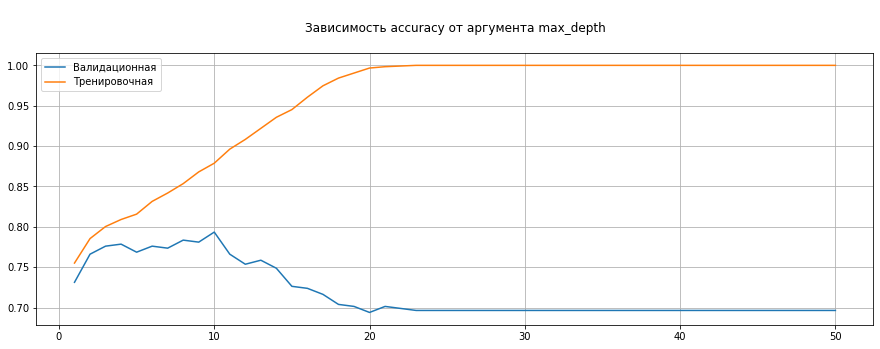

In [10]:
#задаем размер полотна графика 
plt.figure(figsize=(15,5))
#строим два граффика по получинным спискам метрик
plt.plot(range(1,51), valid_accuracy, label='Валидационная')
plt.plot(range(1,51), train_accuracy, label='Тренировочная')
#отображаем легенду
plt.legend()
#сетка
plt.grid()
# Задаем название 
plt.title('\nЗависимость accuracy от аргумента max_depth\n');

<a id="1_answer"></a>
__График валидационной действительно достигает макисмума на значении 10, а вот тренировачная предпочла дастигнуть его в значении 20, скорее всего это связанна с гараздо большим ее размером. Можно предположить, при увеличении количества значений валидационной выборки, увеличится и более подходящее значение `max_depth`.__

Так же для общего развития посмотрим как модель "Дерево решение" будет принимать решение сформированном по тренировочной выборке и с `max_depth` = 3.

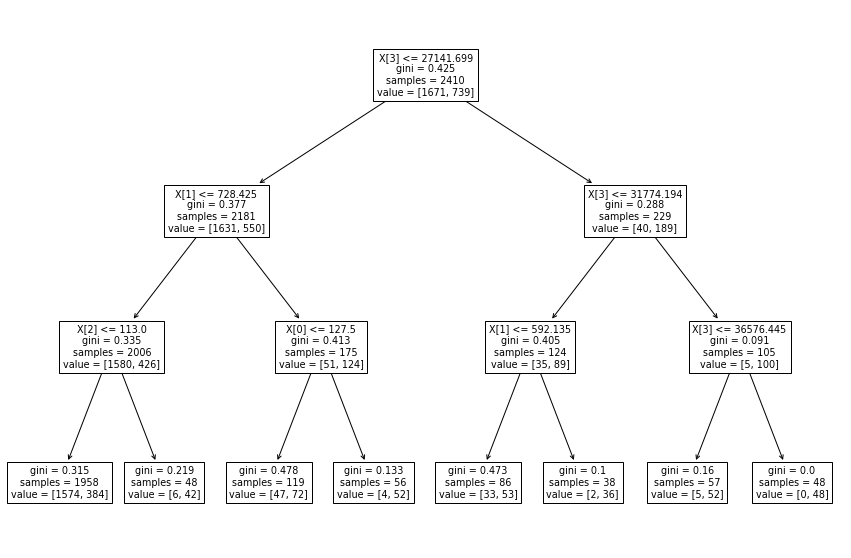

In [11]:
#Создаем модель дерева с гипперпараметромmax_depth = 3
clf = tree.DecisionTreeClassifier(random_state=2503, max_depth = 3)
#Тренируем модель
clf.fit(features_train, target_train)
# Размер шрафика 
plt.figure(figsize=(15,10))
#Постройка граффика.
tree.plot_tree(clf);

__Теперь обучим модель "Линейной регресии". Тут с менять гиперпараметры не будем, так как они еше мало мной изученны. Просто оценим правильность.__
___

In [12]:
%%time
model_log_reg = LogisticRegression()
model_log_reg.fit(features_train, target_train)
accuracy_log_reg = accuracy_score(target_valid, model_log_reg.predict(features_valid))
print('Правильность "accuracy" для модели "Линейной регресии":', round(accuracy_log_reg,4),'\n')

Правильность "accuracy" для модели "Линейной регресии": 0.7065 

CPU times: user 128 ms, sys: 161 ms, total: 289 ms
Wall time: 214 ms


Заметно, что она меньше чем у предыдущей модели. Но тем не менее, она будет учавствовать в сравнении с другими.
___

__Обучим последнюю модель по правилам "Случайного леса". Здесь изменяя гиперпараметры `n_estimators`(количество деревьев) и `max_depth`(глубина каждого дерева) будем влиять на величину полученной правильности. Так же в цикле, но уже со вложенным пройдемся по нескольким значениям выбранных гиперпараметров и выберем наилучшую.__

In [13]:
best_model_rf = None
best_accuracy_rf = 0
best_est_rf = 0
best_depth_rf = 0
for est in tqdm(range(1, 15)):
    for depth in range (1, 15):
        # инициализируйте модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model_random_forest = RandomForestClassifier(random_state=2503, n_estimators=est, max_depth=depth)
        # обучите модель на тренировочной выборке
        model_random_forest.fit(features_train, target_train) 
        # получите предсказания модели на валидационной выборке
        predictions_valid = model_random_forest.predict(features_valid) 
        # посчитайте значение метрики accuracy на валидационной выборке
        accuracy = accuracy_score(target_valid, predictions_valid)
        if accuracy > best_accuracy_rf:
            best_model_rf = model_random_forest
            best_accuracy_rf = accuracy
            best_est_rf = est
            best_depth_rf = depth
print(f"Accuracy наилучшей модели 'Случайного леса' с количество деревьев {best_est_rf},", end=' ') 
print(f'максимальная глубина {best_depth_rf} равно {round(best_accuracy_rf,4)}\n')

100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

Accuracy наилучшей модели 'Случайного леса' с количество деревьев 9, максимальная глубина 9 равно 0.806



Данная модель "Случайного леса" имеет наибольшую правильность (которая также наибольшая среди других видов ошибок) при количестве деревьев 9 с их глубиной в 9.
___

_По обученным моделям можно, заключить что наибольшей правильностью `acuracy` имеет модель "Случайного леса", второй является "Дерево решений", на последнем месте "Линейная регрессия". А вот по времени обучения и оценки этих моделей, все с точности наоборот. Это обьясняется количеством, проходов по выборке для определения самой эффективной. Время можно уменьшить уменьшив обхват значений гиперпараметров `n_estimators` и `max_depth`._

## Проверьте модель на тестовой выборке

Валидационная выборка показала нам оценку правильности `accuracy` всех 3 выбранных моделей наиболее подходящими гипперпараметрами. По показателю правельности самой точной оказалась модель "Случайный лес" именно по ней проведем тестирование. Теперь обучим нашу выбранную модель с выбранными нами параметрами на валидационной и тренировочной выборке вместе. И протестируем на тестовой выборке с параметрами `features_test`, `target_test`.
___

In [14]:
# инициализируйте модель RandomForestClassifier с параметрами random_state=2503, n_estimators=9 и max_depth=9
model_rf = RandomForestClassifier(random_state=2503, 
                                  n_estimators=9, 
                                  max_depth=9
                                 )
# обучите модель на тренировочной выборке
model_rf.fit(pd.concat([features_train, features_valid]), 
             pd.concat([target_train, target_valid])
            )
# получите предсказания модели на валидационной выборке
predictions_rf = model_rf.predict(features_test)

print('Правильность модели "Случайный лес" по тестовой выборке :', round(accuracy_score(target_test, predictions_rf), 4))

Правильность модели "Случайный лес" по тестовой выборке : 0.806


_Видно, что показатель правильности сильно не просел, модель с большей долей вероятности можно назвать рабочей, но для начала проверим ее на адекватность._

## Проверька модели на адекватность

Адекватность модели постараемся разглядеть сравнив ее так сказать c приметивным прогнозом, это прогноз при котором, за правильный выбор модель будет считать самый частое значение в целевой колонке. В первой части мы уже заключили, что в колонке `is_ultra` наиболее вречаемо значение `0`. Но для создания примитивной модели используем модуль `DummyClassifier` с параметром `strategy` равным `most_frequent`, что позволит и заполнить предсказание модели популярным значением целевой колонки. После после обучем на выборке предыдущей части. Протестируем и сравним показатели `accuracy` с нашей моделью "Случайного леса".  
___

In [15]:
#Создаем модель методом DummyClassifier с параметром strategy="most_frequent"
dummy_clf = DummyClassifier(strategy="most_frequent")

# Обучаем на той же выборке
dummy_clf.fit(pd.concat([features_train, 
                         features_valid]), 
             pd.concat([target_train, 
                        target_valid])
             )

# Предсказываем одни 0
dummy_clf.predict(features_test)

print('Правильность примитивной модели по тестовой выборке :', 
      round(accuracy_score(target_test, 
                           dummy_clf.predict(features_test)), 4)
     )

Правильность примитивной модели по тестовой выборке : 0.694


_Видно, что наша премитивная модель гараздо реже угадывала правильный ответ, а тоесть предложение всем клиентам тарифа "смарт" будет менее корректно чем пренятие решение предсказанного нашей моделью "Случайного леса"._

## Вывод

_В работе были обученны три модели для принятия решений по рекомендации пользователям мобильного оператора "Мегалайн", проведенны их сравнения по оценки правельности `accurcy` и отслежанно время работы кода для реализации их обучения, а также принята попытка оценки их адекватной работы.  
По значениям `accuracy`, мы увидели, что "Слуайный лес" является наиболее точным, с результатом 0.8333, чем два остальных метода. Но затрачивающий наибольшие ресурсы для обучения самой качественной модели.  
Самой быстрообучаеммой стала "Логистическая регрессия" крайне слабо обошедшая "Дерево решений"._